In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import glob
from tqdm import tqdm
import io, sys

from dask.distributed import Client
import dask

In [2]:
client = Client(n_workers=14)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45495,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:41967,Total threads: 1
Dashboard: /proxy/37997/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:33125,


In [3]:
# Load bathymetry (full res):
# Data from https://www.gebco.net/data_and_products/gridded_bathymetry_data/
#ds = xr.open_dataset('/g/data/dx2/rmh561/gebco_bathy/GEBCO_2024.nc')
#z = ds.elevation

# Load bathymetry (1/60th-degree):
z_60 = xr.open_dataset('/g/data/dx2/rmh561/gebco_bathy/GEBCO_2024_1arcmin.nc').elevation
z_60.load()

<xarray.DataArray 'elevation' (lat: 10800, lon: 21600)>
array([[ 2830.5   ,  2830.5   ,  2830.5   , ...,  2830.5   ,  2830.5   ,
         2830.5   ],
       [ 2833.75  ,  2833.75  ,  2833.75  , ...,  2833.75  ,  2833.75  ,
         2833.75  ],
       [ 2836.5   ,  2836.5   ,  2836.5   , ...,  2836.5   ,  2836.5   ,
         2836.5   ],
       ...,
       [-4179.75  , -4187.5625, -4195.0625, ..., -4223.    , -4219.875 ,
        -4216.4375],
       [-4178.625 , -4185.8125, -4192.625 , ..., -4225.125 , -4222.25  ,
        -4219.0625],
       [-4177.6875, -4184.375 , -4190.75  , ..., -4227.625 , -4224.9375,
        -4221.875 ]])
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
  * lat      (lat) float64 -89.99 -89.97 -89.96 -89.94 ... 89.96 89.97 89.99
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [ ]:
# Compute 1/60th degree resolution:
z.load()
z_hr = z.coarsen(lon=4).mean().coarsen(lat=4).mean()
z_hr.to_netcdf('/g/data/dx2/rmh561/gebco_bathy/GEBCO_2024_1arcmin.nc')

In [4]:
# Compute various coarsend versions:
z_20 = z_60.coarsen(lon=3).mean().coarsen(lat=3).mean().load()
z_4 = z_60.coarsen(lon=15).mean().coarsen(lat=15).mean().load()
z_1 = z_60.coarsen(lon=60).mean().coarsen(lat=60).mean().load()

In [7]:
# Depth grid:
zgrid = np.arange(-5000.,0.,250.)

# Parameters:
N2 = 1.0e-6
K0 = 1.e-3
B0 = K0*N2
d = 500.
hBBL = 100.
Re=6371000.

# Resolutions to compute:
z_baths = {'1-degree':z_1,'1/4-degree':z_4,'1/20-degree':z_20}#'1/60-degree':z_60,,,}
res = {'1-degree':1,'1/60-degree':1./60.,'1/20-degree':1./20.,'1/4-degree':1./4.}
Enet = {}
EBBL = {}
ESML = {}

for key in z_baths.keys():
    bathy = z_baths[key]
    Enet[key] = xr.DataArray(data=np.zeros_like(zgrid),dims=["z"],coords=dict(z=zgrid))
    EBBL[key] = Enet[key].copy(deep=True)
    ESML[key] = Enet[key].copy(deep=True)

    area = (2*np.pi/360.*Re)**2.*res[key]*res[key]*np.cos(np.pi/180.*bathy.lat)

    for i, z in tqdm(enumerate(zgrid)):
        hab = z - bathy

        # BBL transport:
        omega_BBL = 1/N2*B0/hBBL*area.where(np.logical_and(hab<hBBL,hab>0.))
        EBBL[key][i] = omega_BBL.sum(['lon','lat'])

        # SML transport:
        omega_SML = -1/N2/d*B0*np.exp(-(hab-hBBL)/d)*area.where(hab>hBBL)
        ESML[key][i] = omega_SML.sum(['lon','lat'])

    Enet[key] = EBBL[key] + ESML[key]

20it [00:00, 103.25it/s]
20it [00:00, 22.26it/s]
20it [00:32,  1.62s/it]


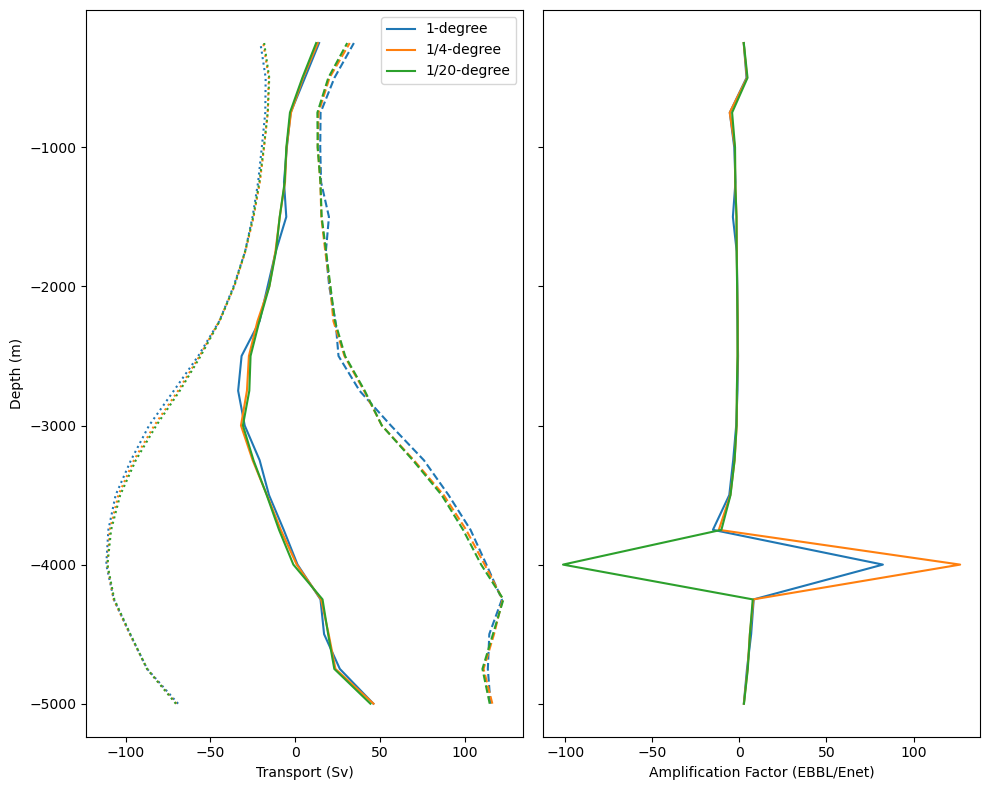

In [28]:
# Do the plots:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,8),sharey=True)

for i, key in enumerate(Enet.keys()):
    (Enet[key]/1e6).plot(y='z',color='C' + str(i),linestyle='-',ax=axes[0],label=key)
    (EBBL[key]/1e6).plot(y='z',color='C' + str(i),linestyle='--',ax=axes[0])
    (ESML[key]/1e6).plot(y='z',color='C' + str(i),linestyle=':',ax=axes[0])

    (EBBL[key]/Enet[key]).plot(y='z',color='C' + str(i),linestyle='-',ax=axes[1])
axes[0].set_ylabel('Depth (m)')
axes[1].set_ylabel('')
axes[0].set_xlabel('Transport (Sv)')
axes[0].legend()
axes[1].set_xlabel('Amplification Factor (EBBL/Enet)')
plt.tight_layout()
plt.savefig('Resolution_Dependence_AmpFactor.png',dpi=150)

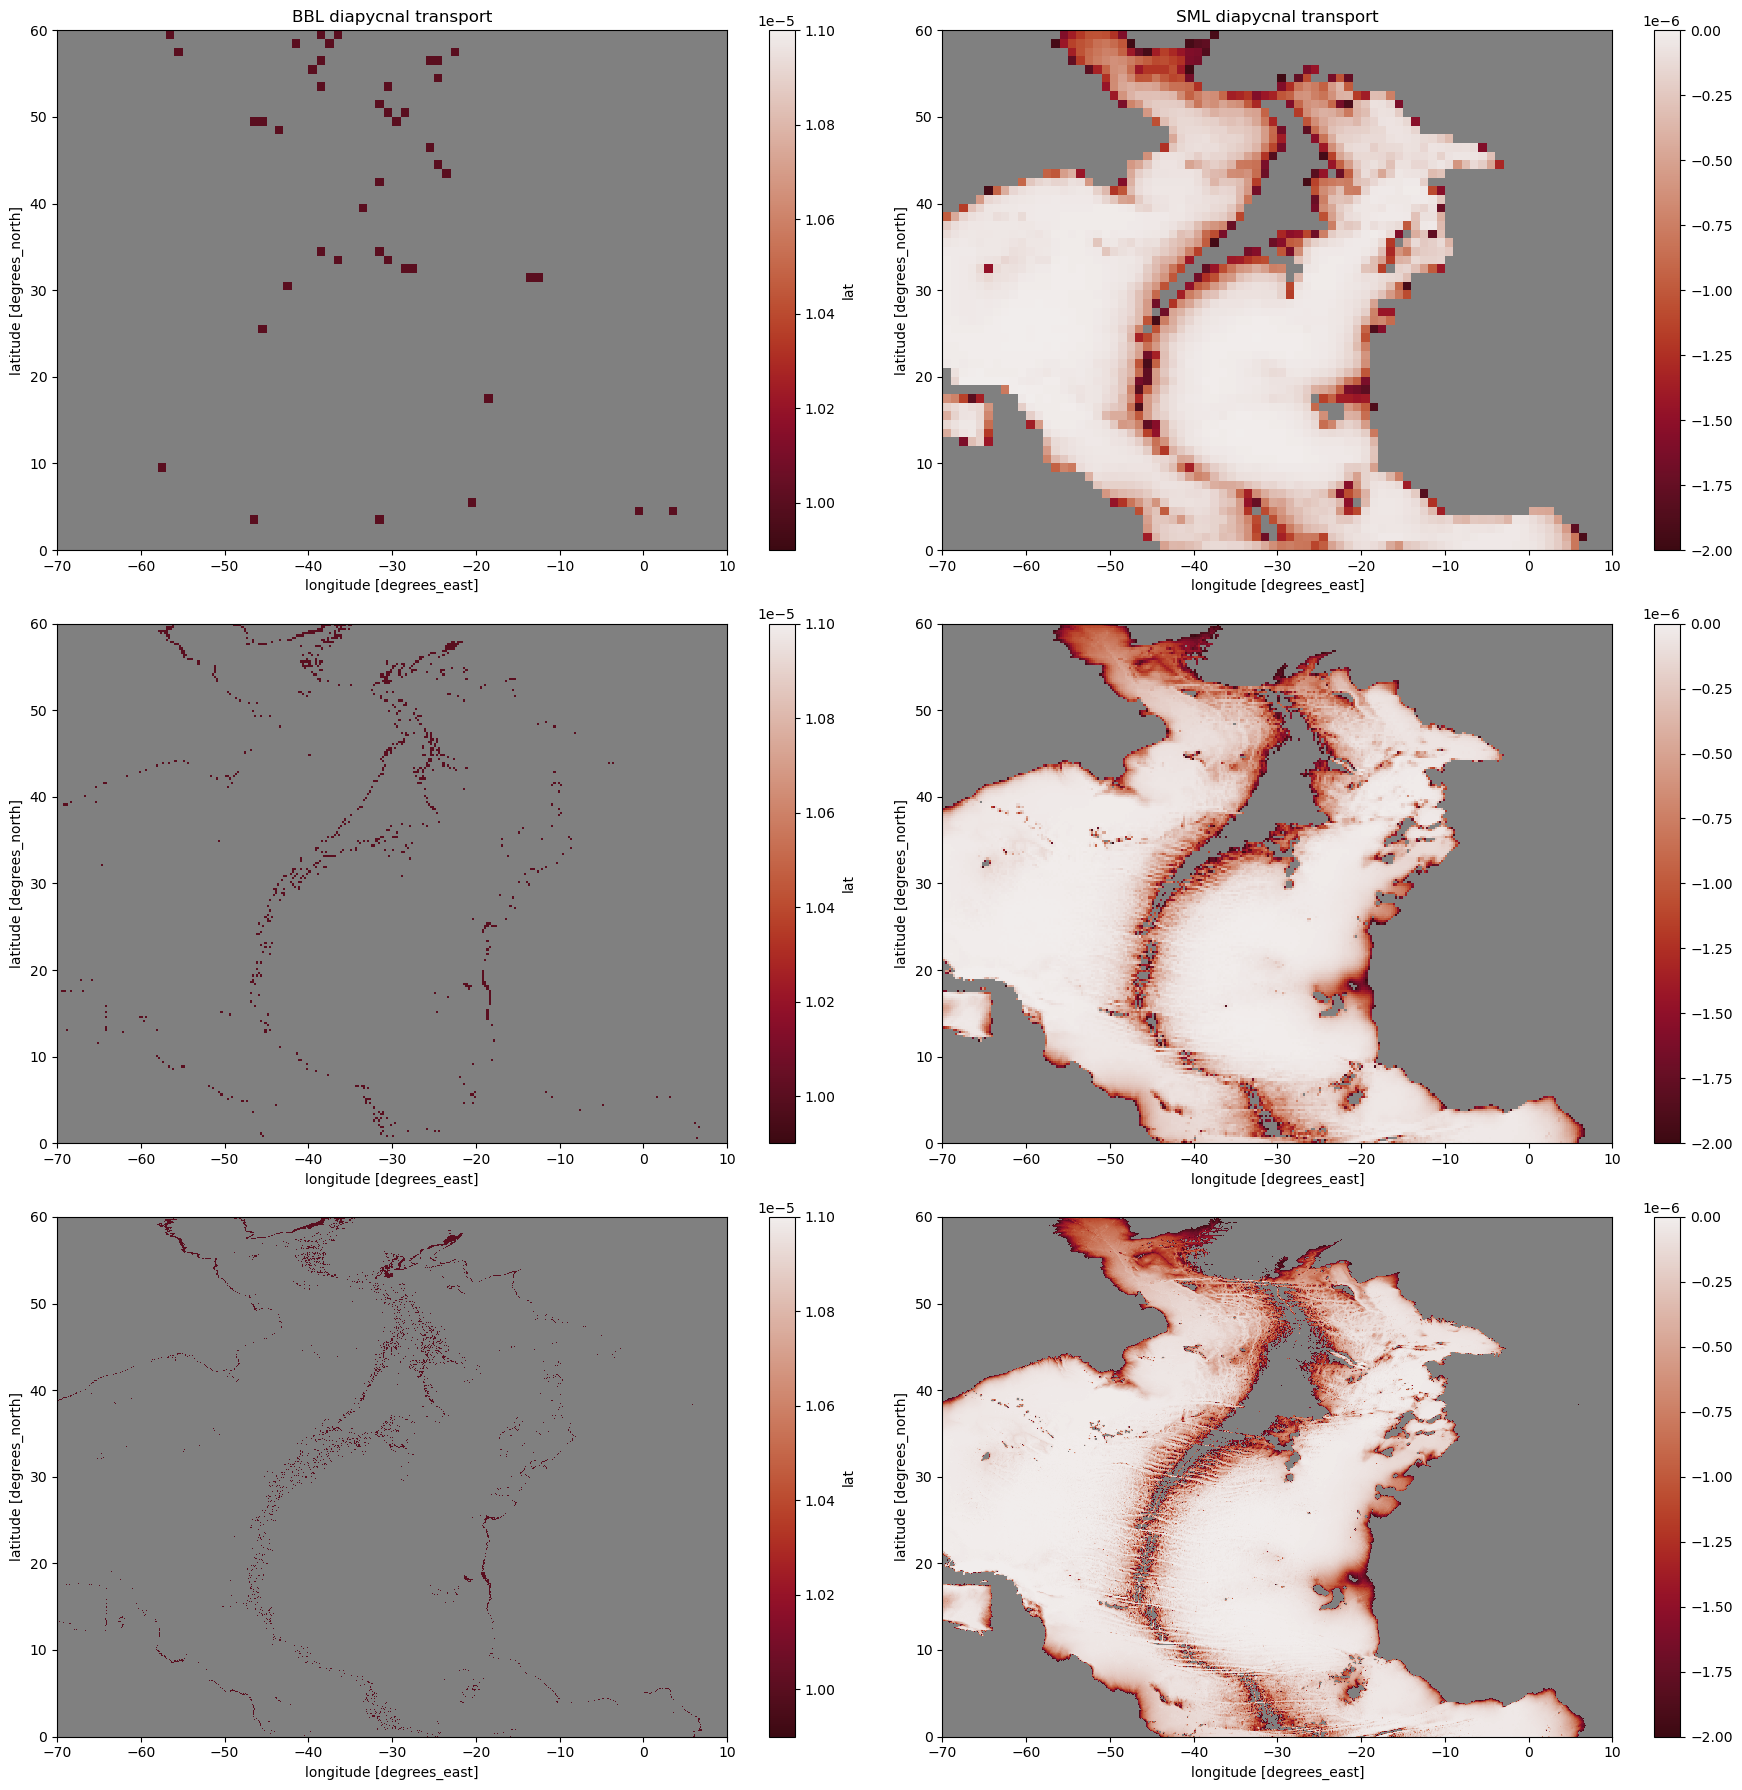

In [25]:
# Plot spatial plots:
ex_z = -3000.
fig, axes = plt.subplots(nrows=len(z_baths.keys()),ncols=2,figsize=(18,18))

for i, key in enumerate(z_baths.keys()):
    bathy = z_baths[key]
    area = (2*np.pi/360.*Re)**2.*res[key]*res[key]*np.cos(np.pi/180.*bathy.lat)
    hab = ex_z - bathy

    # BBL transport:
    omega_BBL = 1/N2*B0/hBBL*area.where(np.logical_and(hab<hBBL,hab>0.))/area.where(np.logical_and(hab<hBBL,hab>0.))

    # SML transport:
    omega_SML = -1/N2/d*B0*np.exp(-(hab-hBBL)/d)*area.where(hab>hBBL)/area.where(hab>hBBL)

    omega_BBL.sel(lon=slice(-70,10),lat=slice(0,60)).plot(ax=axes[i][0],vmin=0.99e-5,vmax=1.1e-5,cmap=cm.cm.amp_r)
    omega_SML.sel(lon=slice(-70,10),lat=slice(0,60)).plot(ax=axes[i][1],vmin=-2e-6,vmax=0.,cmap=cm.cm.amp_r)
for ax in axes.reshape(-1):
    ax.set_facecolor([0.5,0.5,0.5])
axes[0][0].set_title('BBL diapycnal transport')
axes[0][1].set_title('SML diapycnal transport')
plt.tight_layout()
plt.savefig('Resolution_Dependence_AmpFactor_Spatial.png',dpi=150)